## 서울시 공공자전거의 rent장소에서 이용가능성 예측해 보기 

In [0]:
# 구글 드라이브 colab과 연동
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from sklearn.preprocessing import StandardScaler

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import os
import warnings

warnings.filterwarnings('ignore')

In [0]:
df = pd.read_pickle('/content/gdrive/My Drive/project/data.pkl')

## Data Summary
- Dataset size : data.shape
- Get a glimpse of data by printing few rows of it : data.head()
- type check : data.dtypes

In [0]:
df.shape

(6264839, 35)

In [0]:
df.head(2)

In [0]:
df.info()

In [0]:
df.rename(columns={'거치대수':'parkingCount',
                  '구분': 'region',
                  '위도': 'lat',
                  '경도': 'long'}, inplace=True)

In [0]:
bike = df.copy()

In [0]:
bike.describe()

In [0]:
bike.tail()

In [0]:
bike.columns

Index(['number', 'rentplace', 'rentspot', 'returndate', 'returnNo',
       'returnplace', 'returnspot', 'useTime', 'distance', 'dateymd',
       'returnymd', 'rentday', 'renthour', 'rentweek', 'returnday',
       'returnhour', 'returnweek', 'code', 'gender', 'age', 'useCount', 'temp',
       'precipitation', 'wind(m/s)', 'humidity', 'dtemp', 'finedust',
       'ultrafinedust', 'time', 'region', '대여소번호', '대여소명', 'lat', 'long',
       'parkingCount', 'minute', 'year', 'month', 'day'],
      dtype='object')

In [0]:

bike['minute'] = bike.dateymd.dt.minute
bike['year'] = bike.dateymd.dt.year
bike['month']= bike.dateymd.dt.month
bike['day'] = bike.dateymd.dt.day


In [0]:
# numeric value로 바꿔줌. 
bike['age'] = bike.age.map({'0' : 0,
                                    '~10대':1,
                                    '20대':2,
                                    '30대':3,
                                    '40대':4,
                                    '50대':5,
                                    '60대':6,
                                    '70대~':7}).astype(float)
bike['age'].fillna(0,inplace = True)
bike['age'] = bike['age'].astype('int64')


bike['gender'] = bike.gender.map({'F':1, 'M':2}).astype(float)
bike['gender'].fillna(0,inplace = True)
bike['gender'] = bike['gender'].astype('int64')

bike['code'] = bike.code.map({'0' : 0,
                                    '정기':1,
                                    '정기권':1,
                                    '정기(2시간권)':1,
                                    '일일권':2,
                                    '일일(2시간권)':2,
                                    '일일(비회원)':2,
                                    '일일권(비회원)':2,
                                    '단체권':3,
                                    '단체':3}).astype(float)
bike['code'].fillna(0,inplace = True)
bike['code'] = bike['code'].astype('int64')

In [0]:
# finedust

bike.loc[bike['finedust'] <= 30, 'finedust'] = 0
bike.loc[(bike['finedust']>30) & (bike['finedust']<= 50),'finedust'] = 1
bike.loc[(bike['finedust']>50) & (bike['finedust']<= 100),'finedust'] = 2
bike.loc[(bike['finedust']>100) ,'finedust'] = 3
bike['finedust'] = bike['finedust'].astype(int)

In [0]:
# temp data
bike.loc[bike['temp'] <=0, 'temp']=0
bike.loc[(bike['temp'] >0 )&(bike['temp']<=12) , 'temp']=1
bike.loc[(bike['temp'] >12 )&(bike['temp']<=18) , 'temp']=2
bike.loc[(bike['temp'] >18 )&(bike['temp']<=22) , 'temp']=3
bike.loc[(bike['temp'] >22 )&(bike['temp']<=28) , 'temp']=4
bike.loc[bike['temp'] >28, 'temp']=5
bike['temp'] = bike['temp'].astype(int)

In [0]:
# 습도 
bike.loc[(bike['humidity']<= 58), 'humidity'] = 0
bike.loc[(bike['humidity']>58),'humidity'] = 1
bike['humidity'].astype(int)

In [0]:
# number에 str 데이터 전처리
# 마지막 누락 번호로 이어 붙여 주자. 
bike['number'] = bike['number'].replace('위트콤','301') #종로구
bike['number'] = bike['number'].replace('위트콤공장','301') #종로구
bike['number'] = bike['number'].replace('중랑센터','301') # 종로구
bike['number'] = bike['number'].replace('중랑정비팀test 1005','301') # 종로구
bike['number'] = bike['number'].replace('상암센터 정비실','301')  #마포구

In [0]:
# 필요없는 칼럼 드랍
X = bike.drop(['dtemp','time','대여소번호','대여소명'], axis=1)

In [0]:
# 자전거 렌트스팟 갯수로 이용가능성을 수치화 한다. 
X.loc[X['rentspot']< 2, 'availablity' ] = 0
X.loc[X['rentspot']>=2, 'availablity'] = 1

In [0]:
X['total'] = (X['rentspot'] / X['parkingCount'])
#'useCount','gender','code','finedust','ultrafinedust','temp','humidity','rentweek',
#'age','distance','parkingCount','rentspot','returnspot'

In [0]:
# 마포구만
X= X.loc[ X['region']=='마포구'] #(X['region']=='종로구')|

In [0]:
# 종로구만
X= X.loc[X['region']=='종로구'] 

In [0]:
X['rentspot'].describe()

count    499173.000000
mean          5.569690
std           3.657421
min           1.000000
25%           3.000000
50%           5.000000
75%           8.000000
max          41.000000
Name: rentspot, dtype: float64

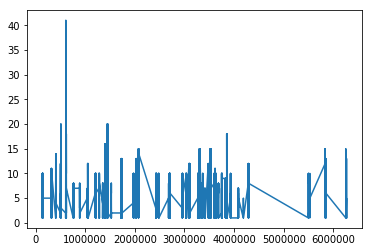

In [0]:
plt.plot(X['rentspot'])

In [0]:
X['total_r'] = X['returnspot'] / X['parkingCount'] 

In [0]:
X['total_r'].describe()

count    6.264839e+06
mean     5.630347e-01
std      4.844347e-01
min      0.000000e+00
25%      2.000000e-01
50%      4.500000e-01
75%      8.000000e-01
max      8.000000e+00
Name: total_r, dtype: float64

In [0]:
X['total'].describe()

count    6.264839e+06
mean     5.090442e-01
std      3.001813e-01
min      0.000000e+00
25%      2.500000e-01
50%      5.000000e-01
75%      7.894737e-01
max      2.562500e+00
Name: total, dtype: float64

In [0]:
X.columns

Index(['number', 'rentplace', 'rentspot', 'returndate', 'returnNo',
       'returnplace', 'returnspot', 'useTime', 'distance', 'dateymd',
       'returnymd', 'rentday', 'renthour', 'rentweek', 'returnday',
       'returnhour', 'returnweek', 'code', 'gender', 'age', 'useCount', 'temp',
       'precipitation', 'wind(m/s)', 'humidity', 'finedust', 'ultrafinedust',
       'region', 'lat', 'long', 'parkingCount', 'minute', 'year', 'month',
       'day', 'total'],
      dtype='object')

In [0]:
# feature 변수를 따로 선언하자. 

# 1. 온습도
feature1 = X[['number','rentweek','renthour','temp','humidity','long','lat','total']]

# 2. 먼지 
feature2 = X[['number','rentweek','finedust','ultrafinedust','long','lat','total']]

# 3. 온습도 + 이용자 특성
feature3 = X[['number','rentweek','humidity','temp','code','age','long','lat','total']]

# 4. 온습도 + 먼지 
feature4 = X[['number','rentweek','humidity','temp','finedust','ultrafinedust','long','lat','total']]


In [0]:
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


## 텐서플로우 패키지 참고 
- https://datascienceschool.net/view-notebook/5cbab09d777841f591a67928d7043f51/

In [0]:
##'finedust',,'number','humidity','gender','age' : 변수를 줄이는것이 문제가 아니고 예측의 범위를 줄이는것이 중요할 것 같다. 

## 종로구에 한정해서 트레인 테스트 셋을 만들어보자. 

In [0]:
xy = X.groupby(['year','month','day','renthour','minute','rentweek','temp', 'finedust','humidity','code','gender','age','number'])['rentspot'].agg({
    'rentspot' : 'mean'}).reset_index()

In [0]:
# Availability 로 label
xy = X.groupby(['year','month','day','renthour','minute','rentweek','temp', 'finedust','humidity','code','gender','age','number'])['availablity'].agg({
    'availablity' : 'mean'}).reset_index()

In [0]:
xy.shape

(339002, 14)

In [0]:
xy.describe()

In [0]:
xy.head(50)

In [0]:
xy.dtypes

year          int64
month         int64
day           int64
renthour      int64
minute        int64
rentweek      int64
temp        float64
finedust    float64
humidity    float64
code          int64
gender        int64
age           int64
number        int64
rentspot    float64
dtype: object

In [0]:
xy['number']= xy.number.astype('str')

## 미래의 특정 number의 rentspot을 예측 
- target_number = '147' 
- target_name = ['rentspot'] / 신호를 예측하는 의미로 다수의 신호를 넣어주어도 된다. 

In [0]:
# 종로구의 147번 거치소의 남아있는 자전거 갯수를 예측 , 미래의 7일을 예측
target_number ='341'
target_name = ['rentspot']

# 24시간의 데이터를 교차이동
shift_days = 1
shift_steps = shift_days *24 # number of hours

# 음수 교차이동임을 확인하고, 새 데이터 프레임을 만든다.  
df_target = xy[target_number][target_name].shift(-shift_steps)

## Scaling의 종류 
- Scikit -learn에서 제공하는 다양한 종류의 스케일러 
1. StandardScaler : 기본 스케일, 평균과 표준편차 사용
2. MinMaxScaler : 최대/최소값이 각각 1, 0이 되도록 스케일링
3. MaxAbsSaler : 최대절대값과 0이 각각 1, 0이 되도록 스케일링
4. RobustScaler : 중앙값(median)과 IQR(interquatile range) 사용, 아웃라이어의 영향을 최소화 


In [0]:
from sklearn.preprocessing import MinMaxScaler
#xy = X [[ 'number','temp','renthour','minute','month','year','rentweek','finedust','humidity','gender','age','code', 'availablity']] # 'humidity','gender','age'
#xy[['year','month','day','renthour','minute','rentweek','temp', 'finedust','humidity','code','gender','age','number','rentspot']]
xy = MinMaxScaler().fit_transform(xy)
x = xy[:,:-1]
y = xy[:,-1]

#x.shape
#y.shape

In [0]:

x = xy[['year','month','day','renthour','minute','rentweek','temp', 'finedust','humidity','code','gender','age','number']]
y = xy[['rentspot']]

In [0]:
x.shape

(339002, 13)

In [0]:
# train/test split _ 시퀀스 없이 그냥 데이터 셋 나누기 
train_size = int(len(y)*0.8)
test_size = len(y)-train_size
#test_size = len(y)*0.1

train_x, test_x = np.array(x[0:train_size]), np.array(x[train_size:len(x)])
train_y, test_y = np.array(y[0:train_size]), np.array(y[train_size:len(y)])
train_y = np.reshape(train_y, (-1,1))

In [0]:

#test_x = np.reshape(test_x, (-1,1))
test_y = np.reshape(test_y, (-1,1))

In [0]:
test_x.shape

(67801, 13)

In [0]:
test_y.shape

(67801,)

In [0]:
len(train_x.shape)

2

In [0]:
len(train_y.shape)

2

In [0]:
len(test_x.shape)

2

In [0]:
len(test_y.shape)

2

## Lgbm 

In [0]:
# 80% 는 학습에 사용하고 20%는 예측에 사용합니다.
split_index = round(X.shape[0] * 0.8)
split_index

399338

In [0]:
# 데이터를 학습과 예측에 사용할 용도로 나눕니다.
# 파이썬의 슬라이싱 기능을 활용해서 나눕니다.
train = X[:split_index].copy()
test = X[split_index:].copy()

print("학습 데이터 크기", train.shape)
print("테스트 데이터 크기", test.shape)

학습 데이터 크기 (399338, 37)
테스트 데이터 크기 (99835, 37)


In [0]:
# 학습과 예측에 사용할 컬럼
# 이용거리를 피처에 추가하고 제외해 본다.
feature_columns = ['year','month','day','renthour','minute','rentweek','temp', 'finedust','humidity','code','gender','age','number']
feature_columns

['year',
 'month',
 'day',
 'renthour',
 'minute',
 'rentweek',
 'temp',
 'finedust',
 'humidity',
 'code',
 'gender',
 'age',
 'number']

In [0]:
#label_column = "rentspot"
label_column = "availablity"
label_column

'availablity'

In [0]:
# 학습, 예측에 사용할 컬럼만 추출
train_x = train[feature_columns].copy()
test_x = test[feature_columns].copy()

print("학습에 사용할 피처 크기", train_x.shape)
print("예측에 사용할 피처 크기", test_x.shape)

학습에 사용할 피처 크기 (399338, 13)
예측에 사용할 피처 크기 (99835, 13)


In [0]:
train_y = train[label_column]

In [0]:
test_y = test[label_column]

In [0]:
import lightgbm as lgbm

def runLGBM(train_x, train_y, test_x, seed_val=42):
    params = {
        'boosting_type': 'gbdt', 'objective': 'regression', 'nthread': -1, 'verbose': 0,
        'num_leaves': 31, 'learning_rate': 0.05, 'max_depth': -1,
        'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.6, 
        'reg_alpha': 1, 'reg_lambda': 0.001, 'metric': 'rmse',
        'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 10, 'scale_pos_weight': 1}
    
    pred_test_y = np.zeros(test_x.shape[0])
    
    train_set = lgbm.Dataset(train_x, train_y, silent=True)
        
    model = lgbm.train(params, train_set=train_set, num_boost_round=300)
    pred_test_y = model.predict(test_x, num_iteration = model.best_iteration)
        
    return pred_test_y , model

In [0]:
y_predict_lgbm, model = runLGBM(train_x, train_y, test_x, seed_val=42)

In [0]:
# 예측값을 정답값과 비교해 주기 위해 y데이터 프레임에 담아준다. 
test["rentspot(lgbm)"] = y_predict_lgbm

## lgbm 평가 

In [0]:
# 성능 평가 비교를 위해 score 변수를 만든다.
score = {}
score["LGBM"] = {}

In [0]:
# MAE - Mean Absolute Error
# 실제값과 예측값의 차이에 절대값을 씌운 후 평균을 구한다.
score["LGBM"]["MAE"] = abs(y_predict_lgbm - test_y).mean()
score["LGBM"]["MAE"]

In [0]:
# RMSE - Root Mean Square Error
# 실제값과 예측값의 차이에 제곱을 해서 음수를 양수로 만들고 평균값을 구한 후 루트를 씌워준다.
score["LGBM"]["RMSE"] = np.sqrt(
    ((y_predict_lgbm - test_y)**2).mean()
)
score["LGBM"]["RMSE"]

0.38708440566820934

In [0]:
score

{'LGBM': {'RMSE': 0.38708440566820934}}

## RandomForest regression

In [0]:
from sklearn.ensemble import RandomForestRegressor
# 모델 선언
rf = RandomForestRegressor()
# 학습
rf.fit(train_x, train_y)
# 예측
rf_predict = rf.predict(test_x)
print(rf_predict)
#print('rmsle value for random forest: ', rmsle(np.exp(np.log1p(test_y)), np.exp(rf_predict), False))

test['predict_spot(rf)'] = rf_predict

[0.9   1.    1.    ... 0.85  0.85  0.875]


In [0]:
# 평가 
score['rf']= {}

# RMSE - Root mean square error
score['rf']['RMSE'] = np.sqrt(
    ((rf_predict - test_y)**2).mean()
)
score['rf']['RMSE']

0.4297993543157341

## Linear Regression
use RMSLE

In [0]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다. 
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다. 
    calc = (log1 - log2) ** 2
    # 평균을 내고 다시 루트를 씌운다. 
    return np.sqrt(np.mean(calc))

In [0]:

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits= 10, shuffle = True, random_state = 0)

In [0]:

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = train_x,y = np.log1p(train_y))

# Make predictions
preds = lModel.predict(X= test_x)
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(test_y)),np.exp(preds),False))

RMSLE Value For Linear Regression In Validation:  0.15651283421493012


In [0]:
test['linear_rentspot'] = preds
score['linear'] = {}
score['linear']['RMSE']= np.sqrt(
    ((preds - test_y)**2).mean()
)
score["linear"]["RMSE"]

0.4416881602965593

In [0]:
test.head()

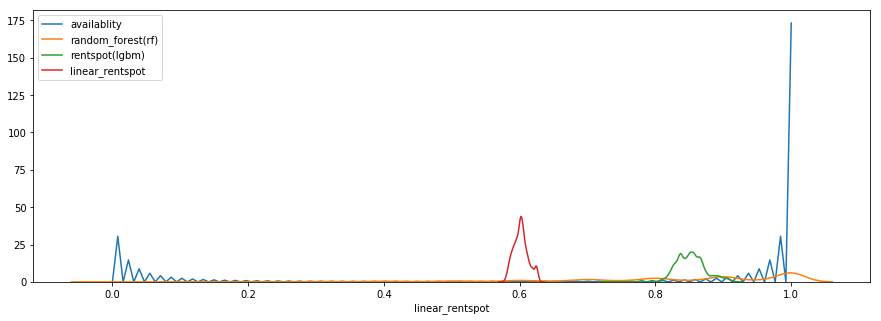

In [0]:
plt.figure(figsize=(15, 5))
sns.distplot(test[label_column], label=label_column, hist=False)
sns.distplot(test["predict_spot(rf)"], label="random_forest(rf)", hist=False)
sns.distplot(test["rentspot(lgbm)"], label="rentspot(lgbm)", hist=False)
sns.distplot(test["linear_rentspot"], label="linear_rentspot", hist=False)

[Text(0.5, 1.0, 'Test Set Distribution')]

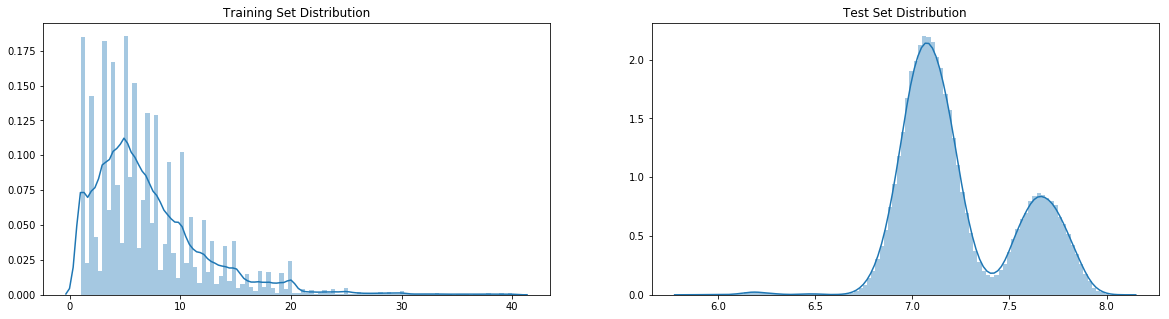

In [0]:
import seaborn as sn
predsTest = lModel.predict(X=test_x)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(test_y,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distribution")
ax2.set(title="Test Set Distribution")

## Regularization Model - Ridge

In [0]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

{'alpha': 800, 'max_iter': 3000}
-0.13814114414589992
rmsle Value For ridge regression: 0.15651174039329083


AttributeError: ignored

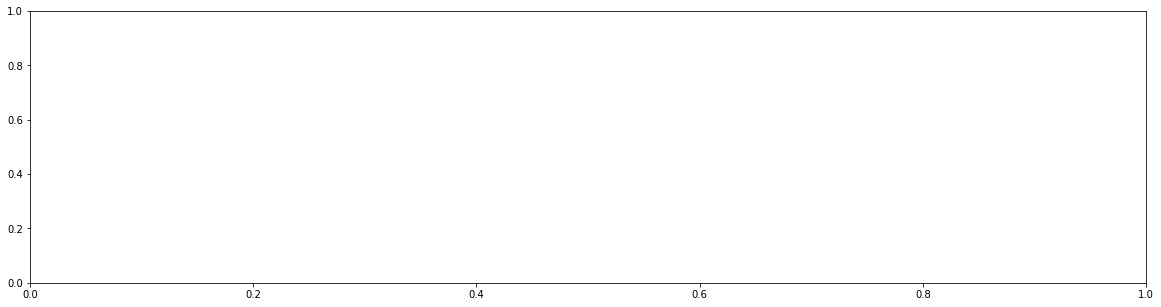

In [0]:


ridge_m_= Ridge()
ridge_params_ = {'max_iter':[3000], 'alpha':[0.01, 0.05,0.1, 1, 2, 3, 4, 10, 30, 100, 200, 400, 800]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better= False)
gride_ridge_m = GridSearchCV(ridge_m_,
                             ridge_params_,
                             scoring = rmsle_scorer,
                             cv = 5)
gride_ridge_m.fit(X= train_x, y= np.log1p(train_y))
preds = gride_ridge_m.predict(X = test_x)
print(gride_ridge_m.best_params_)
print(gride_ridge_m.best_score_)
print('rmsle Value For ridge regression:', rmsle(np.exp(np.log1p(test_y)), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
df = pd.DataFrame(gride_ridge_m.grid_scores_) #cv_results_,  grid_scores_

df['alpha'] = df['parameters'].apply(lambda x : x['alpha'])
df['rmsle'] = df['mean_validation_score'].apply(lambda x : -x)
sn.pointplot(data=df, x='alpha', y = 'rmsle', ax=ax)
#gride_ridge_m.score(train_x, train_y), gride_ridge_m.best_score_


## Multi Regression

In [0]:
test_x = np.reshape(test_x, (-1,1))

In [0]:
test_x.shape

(67801, 13)

In [0]:
tf.set_random_seed(777)
X = tf.placeholder(tf.float32, shape=(None, 13))
Y = tf.placeholder(tf.float32, shape = (None,1 ))

W = tf.Variable(tf.random_normal([13,1]), name = 'weight')
b = tf.Variable(tf.random_normal([1]), name='bias')

In [0]:
# 가설함수 
hypothesis = tf.sigmoid(tf.matmul(X,W)+b)

loss = -tf.reduce_mean(Y*tf.log(hypothesis)+ (1-Y)*tf.log(1-hypothesis))
train = tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(loss)

predict = tf.cast(hypothesis >0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predict, Y), dtype=tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(5000):
        loss_val, _ = sess.run([loss, train], feed_dict={X:train_x, Y:train_y})

        if step %200 ==0:
            print(step, loss_val)

    h, p, a = sess.run([hypothesis, predict, accuracy], feed_dict={X:test_x, Y:test_y})
    print("\nHypothesis : ", h, "\nPredict : ", p, "\nAccuracy: ", a)

0 1.4298147
200 1.4007341
400 1.3723304
600 1.3446028
800 1.3175483
1000 1.2911642
1200 1.265446
1400 1.2403892
1600 1.2159884
1800 1.1922367
2000 1.1691277
2200 1.1466532
2400 1.1248052
2600 1.1035758
2800 1.0829542
3000 1.0629307
3200 1.0434961
3400 1.024639
3600 1.0063483
3800 0.9886127
4000 0.97142065
4200 0.95476055
4400 0.9386199
4600 0.92298645
4800 0.90784883

Hypothesis :  [[0.8254406 ]
 [0.82220507]
 [0.819583  ]
 ...
 [0.51862305]
 [0.5163965 ]
 [0.508599  ]] 
Predict :  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]] 
Accuracy:  0.70824915


In [0]:
y['multilinear_rentspot'] = p
score['multilinear_rentspot'] = {}
score['multilinear_rentspot']['RMSE']= np.sqrt(
    ((predict - test_y)**2).mean()
)
score["multilinear_rentspot"]["RMSE"]

IndexError: ignored

## RNN 
- 우리는 왜 RMSE를 사용할까?
: 보통 고양이 개 타겟값을 예측하는 분류모델에서는 정확도의 의미가 있지만, 
수치형의 모델에서는 정확도를 예측하는 것이 조금 애매하다. 그래서 regression문제 에서는 크기의존적 에러값을 중요시한다. 

- RMSE 는 함수로도 표현할 수 있고, regression loss function으로 
: model.compile(loss = 'mean_squared_error', optimizer = 'adam') 처럼 표현할 수 있다. 

- 단점:!! 크기 의존적이므로 대상의 크기에 영향을 받는다. 

In [0]:
# train parameters
seq_length = 7
data_dim = 13
hidden_dim = 10
output_dim = 1 # batch dim
learning_rate = 0.01
iterations = 1000


In [0]:
# build the dataset
dataX = []
dataY = []
for i in range(0, len(y)- seq_length):
  _x = x[i: i+ seq_length]
  _y = y[i + seq_length]
  #print(_x, '->', _y)
  dataX.append(_x)
  dataY.append(_y)

In [0]:
print(np.asarray(dataX).shape)

(338995, 7, 13)


In [0]:
print(np.asarray(dataY).shape)

(499166,)


In [0]:
# train/test split
train_size = int(len(dataY)*0.8)
test_size = len(dataY)-train_size

train_x, test_x = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
train_y, test_y = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])
train_y = np.reshape(train_y, (-1,1))
test_y = np.reshape(test_y, (-1,1))

In [0]:
test_size

99834

In [0]:
train_x.shape

(399332, 7, 12)

In [0]:
train_y.shape

(399332, 1)

In [0]:
test_x.shape

(1252967, 7, 12)

In [0]:
tf.reset_default_graph()

# input placeholders
tf.set_random_seed(777)
X = tf.placeholder(tf.float32, [None,seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

#print(X.graph)
#X = tf.expand_dims(X, axis = 2)

In [0]:
# build LSTM network
#tf.reset_default_graph()
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units = hidden_dim, state_is_tuple = True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
#tf.reset_default_graph()



In [0]:
# hypothesis
#마지막 hidden state를 이용하여 타켓을 예측하는 Y_pred생성
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:,-1], output_dim, activation_fn = None)



In [0]:
Y_pred

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, 1) dtype=float32>

In [0]:
print(Y)
#Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)

Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [0]:
# cost/ loss : MEE
loss = tf.reduce_sum(tf.square(Y_pred - Y))

# optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE : route mean squared error
targets = tf.placeholder(tf.float32, [None,1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))





In [0]:
with tf.Session() as sess:
  init = tf.global_variables_initializer()
  sess.run(init)

  # training step
  for i in range(iterations):
    _, step_loss = sess.run([train, loss], feed_dict={X: train_x, Y: train_y })
    if i%100==0:
      print("[step: {}] loss : {} ".format(i, step_loss))

  # test step 
  test_prediction = sess.run(Y_pred, feed_dict = {X: test_x})
  rmse_val = sess.run(rmse, feed_dict={targets: test_y, predictions : test_prediction})
  print('rmse : {}'.format(rmse_val))



[step: 0] loss : 426172.96875 
[step: 100] loss : 31806.263671875 
[step: 200] loss : 31755.76171875 
[step: 300] loss : 31735.068359375 
[step: 400] loss : 31727.19140625 
[step: 500] loss : 31723.83203125 
[step: 600] loss : 31721.94921875 
[step: 700] loss : 31720.576171875 
[step: 800] loss : 31719.4296875 
[step: 900] loss : 31718.41796875 
rmse : 0.2936571538448334
